# Closest Pair of Points

Given a list of points in a 2D plane, the objective is to identify the closest pair of points. The most straightforward method involves calculating the distance between every pair of points and determining the minimum distance. Although this naive approach is effective, it has a time complexity of $O(n^2)$, which can be inefficient for large datasets.

To enhance efficiency, a divide and conquer strategy can be employed, reducing the time complexity to $O(n \log^2 n)$. This method involves splitting the points into two halves, recursively finding the closest pair of points in each half, and then merging the results to identify the closest pair that straddles the boundary between the two halves. The smallest of these distances will be the solution.

Though the divide and conquer approach seem more complex. A geometrical constraint is used to reduce the number of comparisons required to find the closest pair of points. This will be explained in detail in the code comments.

## The naive approach

```cpp
PointPair RClosestPairPoint(std::vector<Point> & P) {
    double min = P[0] & P[1];
    PointPair res={P[0], P[1]};
    for (int i = 0; i < P.size(); i++) 
        for (int j = i+1; j < P.size(); j++) 
            if ((P[i] & P[j]) < min && i!=j) {
                min = P[i] & P[j]; // & is the distance between two points
                res = {P[i], P[j]};
            }
    return res;
}
```

## Closest Pair of Points - Divide and Conquer approaches
There are multiple approaches to solve the closest pair of points problem using divide and conquer. The most common ones are:
1. Regular Divide and Conquer
    The given list is sorted by x-coordinate. Then the list is divided into two halves. The closest pair of points in each half is found recursively. The minimum of the two distances is the minimum distance in the whole list. The points are then sorted by y-coordinate and the points within the strip of width 2d and height d are checked for the closest pair of points. The time complexity of this approach is $O(n*log^2(n)$ and the space complexity is $O(n)$. 
2. Presorted Y list with Divide and Conquer
    Another copy of list is made with the points sorted by y-coordinate. While finding the closest pair of points in the strip, the points are looked up by an O(n) search in this list. 
    The list is divived into each cores available then all intersections are merged.
3. All divisions to thread
    All divisions are done in threads and the results are merged.
4. CPU core optimized Divide and Conquer

### Regular Divide and Conquer

```cpp
PointPair DCClosestPairPoints(std::vector<Point> & P) {
    std::sort(P.begin(), P.end());
    return dccpp(P, 0, P.size()-1); 
}
PointPair dccpp(std::vector<Point>&points,int l, int r) {
    if (r-l == 1)   return {points[l], points[r]}; // O(1)

    if (r-l == 2) { // O(1)
    
        double d1 = points[l+1]  & points[l];
        double d2 = points[l]      & points[r];
        double d3 = points[l+1] & points[r];

        if          (d1 < d2 && d1 < d3)   return {points[l], points[l+1]};
        else if (d2 < d3)                        return {points[l]  ,   points[r]};
        else                                            return {points[l+1], points[r]};

    }

    int m = (l+r)/2;

    PointPair smallest = std::min(dccpp(points, l, m),dccpp(points, m+1, r));
    double d = smallest;

    // Divide and search
    auto start = points.begin() + l;
    auto end   = points.begin() + r;
    auto lower = std::lower_bound(start, end, Point(points[m].x - d, 0)); // O(log n)
    start = lower;
    auto upper = std::upper_bound(start, end, Point(points[m].x + d, 0)); // O(log n)
    if (upper == points.end()) upper = end;
    std::vector<Point> strip(lower, upper);
    // Sort the strip by y coordinate.
    std::sort(strip.begin(), strip.end(), Point()); // O(n log n) - n is the size of the strip: which can be at most (l-r)/2

    // Search the strip
    /* HOW TO SEARCH THE STRIP
     *
     * The smallest distance is d
    *  In the X axis, the distance between two points is d, i.e. from the middle point there can be shorterdistances in a d radius circle
    * However moving from up to down we do not need to consider all points, only the ones that are below is enough -  as the points are sorted by y coordinate.
    * For simplicity, We search a rectangle instead of a circle. Now the dimention of the rectangle is 2d x d.
    * Now from each sections we will get at most 8 points apart by distance d. any point more than change will change d - which is not possible. So we only need to check the other 7 points. for each point we will check the distance and update the smallest distance.
    * The time complexity of this part is O(n) - as we are only checking 8 points for each point in the strip.
    */
    for (int i = 0; i < (int)strip.size(); i++) // O(n)
        for (int j=i+1;j<i+8&& j<(int)strip.size();j++)  // O(1)
            if ((strip[i] & strip[j]) < d) d = smallest = {strip[i], strip[j]};
    
    return smallest;
}
```


### Presorted Y list with Divide and Conquer
```cpp
PointPair DCClosestPairPointsY(std::vector<Point>& P) {
  // Presorted x & y
  std::sort(P.begin(), P.end());
  std::vector<Point> pointY = P;
  std::sort(pointY.begin(), pointY.end(), Point());
  return dccpp_ysorted(P, pointY, 0, P.size() - 1);
}
```
Instead of founding in the lower, upper bound range of the strip, the points are found by a linear search in the sorted y list. This reduces the time complexity of the strip search to O(n).
```cpp
 std::vector<Point> strip;
  for (int i = 0; i < pointY.size(); i++) {
    if (pointY[i].x >= points[m].x - d && pointY[i].x <= points[m].x + d)
      strip.push_back(pointY[i]);
  }
  ```

### All divisions to threads
```cpp
auto future_left = std::async(std::launch::async, dccppP, std::ref(points), l, m);
auto future_right = std::async(std::launch::async, dccppP, std::ref(points), m + 1, r);
PointPair smallest = std::min(future_left.get(), future_right.get());
```

### Parrallel Divide and Conquer - CPU core optimized

```cpp
//this is an extra wrapper
PointPair DCClosestPairPointsP(std::vector<Point>& points) {
  // CPU core aware parallel divide and conquer
  // Sort the points by x coordinate
  std::sort(points.begin(), points.end());
  int n = points.size();
  int num_threads = std::thread::hardware_concurrency();
  int chunk_size = n / num_threads;

  std::vector<std::future<PointPair>> futures;
  // broken to number of hardware threads
  for (int i = 0; i < num_threads; ++i) {
    int start = i * chunk_size;
    int end = (i == num_threads - 1) ? n - 1 : (i + 1) * chunk_size - 1;
    futures.push_back(
        std::async(std::launch::async, dccpp, std::ref(points), start, end));
  }

  // get smallest distance from all threads
  PointPair smallest = futures[0].get();
  for (int i = 1; i < num_threads; ++i) {
    PointPair result = futures[i].get();
    if (result < smallest) smallest = result;
  }

  double d = smallest;
  std::vector<Point> strip;

  // merge the results from each strip
  for (int i = 0; i < num_threads - 1; i++) {
    //similar to the above function's merge
    int l = i * chunk_size;
    int r = (i == num_threads - 2) ? n - 1 : (i + 2) * chunk_size - 1;
    int m = (l + r) / 2;
    auto start = points.begin() + l;
    auto end = points.begin() + r + 1;
    auto lower = std::lower_bound(start, end, Point(points[m].x - d, 0));
    start = lower;
    auto upper = std::upper_bound(start, end, Point(points[m].x + d, 0));
    std::vector<Point> strip(lower, upper);
    std::sort(strip.begin(), strip.end(), Point());
    for (int i = 0; i < (int)strip.size(); i++)
      for (int j = i + 1; j < i+8 && j < (int)strip.size(); j++)
        if ((strip[i] & strip[j]) < d) d = smallest = {strip[i], strip[j]};
  }

  return smallest;
}
```

## Impementation Dificulties
Learning for stress testing closest pair finding, I used `srand` with different seeds ranging from 0 to $10^6$. To find the smallest `n` that causes an error, I ran a loop from 2 to $10^6$ with the following logic:

- If `z -= 2` and `z < 100`, then increment `z++`.
- For `k = 0; k < 10^6; k++`:
    - Set `srand(k)`.
    - Create a vector of size `z` with random elements.
    - Run the algorithm.
    - Find mismatches with the brute force method.
Then the problem I found was - while checking the 7 points, I wrote
```cpp
for (int i = 0; i < (int)strip.size(); i++)
      for (int j = i + 1; j < 8 && j < (int)strip.size(); j++)
```
instead of
```cpp
for (int i = 0; i < (int)strip.size(); i++)
      for (int j = i + 1; j < i+8 && j < (int)strip.size(); j++)
```

## Performane Analysis
### Complexity
#### Naive Approach
Two nested loops are used to calculate the distance between every pair of points, resulting in a time complexity of $O(n^2)$.
#### Divide and Conquer Approach
The divide and conquer approach for finding the closest pair of points has a time complexity of $O(n \log^2 n)$. Here's the derivation:

1. **Divide Step**: The list of points is divided into two halves. This step takes $O(\log n)$ time as the list is recursively divided until each half contains a single point.

2. **Merge Step**: The points are merged by checking the strip of width $2d$ around the dividing line. Sorting the points in the strip by their y-coordinates takes $O(n \log n)$ time. Checking the points within the strip takes $O(n)$ time.

Combining these steps, the overall time complexity is:
$T(n) = 2T\left(\frac{n}{2}\right) + O(n \log n)$

Using the Master Theorem for divide and conquer recurrences, we get:
$T(n) = O(n \log^2 n)$

Thus, the time complexity of the divide and conquer approach for finding the closest pair of points is $O(n \log^2 n)$

## Real world performance

### Zero Optimization

#### Closest Pair Benchmark

> Time is in seconds, lower is better

|   NumPoints |          DC |   DCYPreSorted |   DCParallelized |   DCAllThreaded |     NSquare |
|------------:|------------:|---------------:|-----------------:|----------------:|------------:|
|         100 | 5.1414e-05  |     4.7247e-05 |      0.000237857 |      0.00167946 |  5.5723e-05 |
|        1000 | 0.000639583 |     0.00105661 |      0.000462259 |      0.0221673  |  0.00443734 |
|       10000 | 0.00734789  |     0.00917589 |      0.00347153  |      0.196966   |  0.396161   |
|      100000 | 0.0834607   |     0.102471   |      0.0752005   |      1.71027    | 40.9844     |

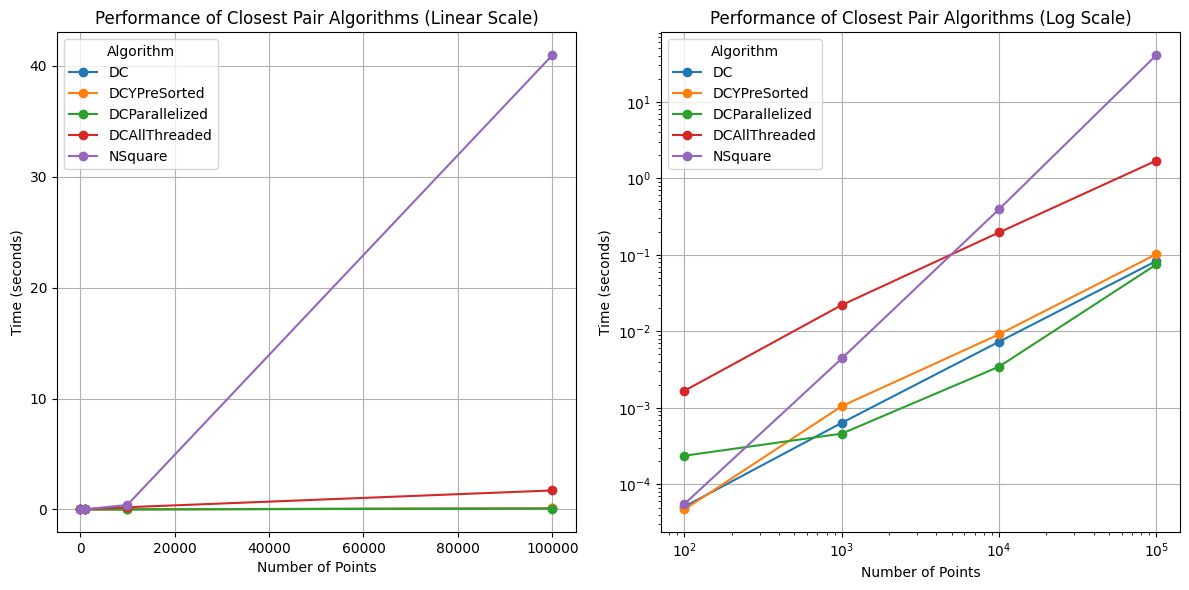

### O3 Optimization

#### Closest Pair Benchmark

> Time is in seconds, lower is better

|   NumPoints |          DC |   DCYPreSorted |   DCParallelized |   DCAllThreaded |    NSquare |
|------------:|------------:|---------------:|-----------------:|----------------:|-----------:|
|         100 | 1.6747e-05  |    1.2527e-05  |      0.000285396 |       0.0017039 | 1.1101e-05 |
|        1000 | 0.000137616 |    0.000156419 |      0.000203995 |       0.0320875 | 0.0016567  |
|       10000 | 0.00142858  |    0.00207598  |      0.00090655  |       0.225845  | 0.0901237  |
|      100000 | 0.0199273   |    0.0290461   |      0.0116812   |       2.03635   | 8.53675    |

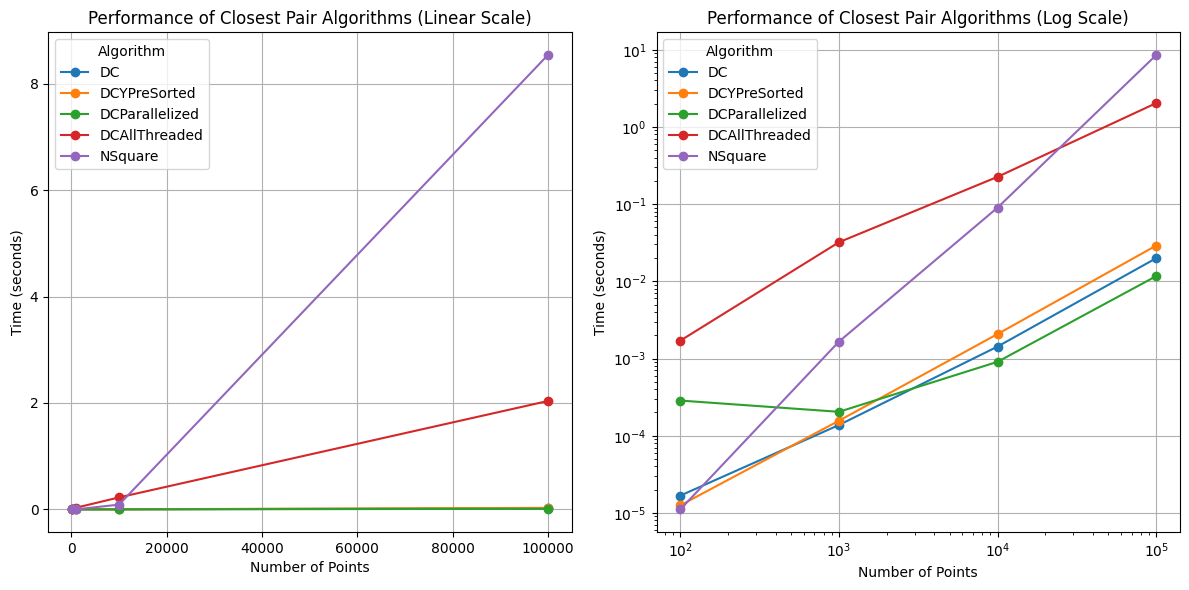

### Fast Optimization

#### Closest Pair Benchmark

> Time is in seconds, lower is better

|   NumPoints |          DC |   DCYPreSorted |   DCParallelized |   DCAllThreaded |     NSquare |
|------------:|------------:|---------------:|-----------------:|----------------:|------------:|
|         100 | 1.645e-05   |     1.2058e-05 |      0.00179236  |      0.00228705 | 9.245e-06   |
|        1000 | 0.000138309 |     0.00017949 |      0.000241001 |      0.0240178  | 0.000810714 |
|       10000 | 0.0016976   |     0.00207099 |      0.00179181  |      0.240741   | 0.086563    |
|      100000 | 0.0202559   |     0.0285635  |      0.0100885   |      1.88816    | 8.14054     |

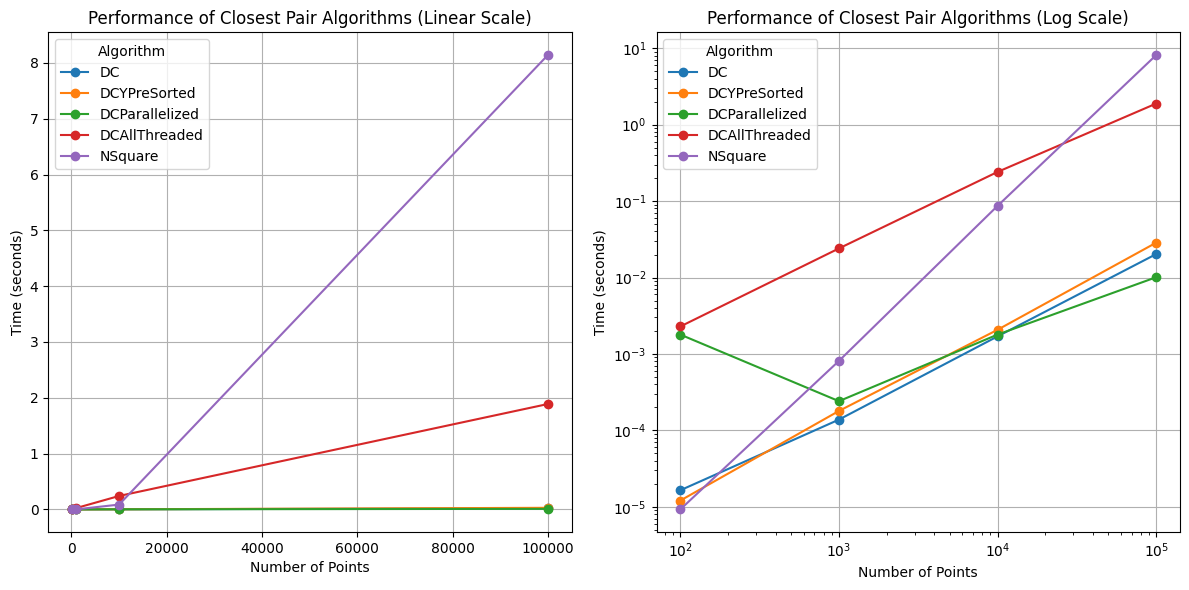

In [5]:
display(Markdown('### Zero Optimization'))
plot_closest_pair_benchmark('./O0/closest_pair_benchmark.csv')
display(Markdown('### O3 Optimization'))
plot_closest_pair_benchmark('./O3/closest_pair_benchmark.csv')
display(Markdown('### Fast Optimization'))
plot_closest_pair_benchmark('./fast/closest_pair_benchmark.csv')

It is visible from the graph that the divide and conquer approach is much faster than the naive approach. The all divisions to threads approach is the slowest among all D&C algorithms as the overhead of creating threads is more than the time saved by parallelism. The CPU core optimized approach is the fastest among all as it uses the hardware threads efficiently. Though the Y presorted approach promises $O(nlog(n))$ it was slower than the regular divide and conquer approach. As the presorted Y list is not used in the strip search, the time complexity of the strip search is still $O(n)$.
For smaller inputs however the cpu core aware approach is slower due to over heads.

# Matrix Multiplication
Matrix multiplication is one of the most used operations in linear algebra and computer science. The naive approach to matrix multiplication involves three nested loops to calculate the product of two matrices. This method has a time complexity of $O(n^3)$, which can be inefficient for large matrices.
Though there are currently many approaches to optimize this via hardware or software, the first optimization is the Strassen algorithm. The Strassen algorithm reduces the number of multiplications required to calculate the product of two matrices, resulting in a time complexity of $O(n^{2.81})$. This algorithm is based on the principle of divide and conquer, where the matrices are divided into submatrices and the product is calculated using these submatrices.

## The naive approach
```cpp
std::vector<std::vector<int>> res(dim, std::vector<int>(dim));
        for (int i = 0; i < dim; i++)
            for (int j = 0; j < dim; j++)
                for (int k = 0; k < dim; k++) res[i][j] += mat[i][k] * other.mat[k][j];
        return MatrixRegular(res);
```

## Strassen Algorithm
A square matrix of size $2^n$ can be divided into four submatrices of size $2^{n-1}$. For 
$$
C = A \cdot B
$$
$$
A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}
$$
$$
B = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix}
$$
$$
C = \begin{bmatrix} C_{11} & C_{12} \\ C_{21} & C_{22} \end{bmatrix}
$$

The Strassen algorithm is based on the following formula:
$$ 
\begin{aligned}
P_1 &= (A_{11} + A_{22}) \cdot (B_{11} + B_{22}) \\
P_2 &= (A_{21} + A_{22}) \cdot B_{11} \\
P_3 &= A_{11} \cdot (B_{12} - B_{22}) \\
P_4 &= A_{22} \cdot (B_{21} - B_{11}) \\
P_5 &= (A_{11} + A_{12}) \cdot B_{22} \\
P_6 &= (A_{21} - A_{11}) \cdot (B_{11} + B_{12}) \\
P_7 &= (A_{12} - A_{22}) \cdot (B_{21} + B_{22}) \\
\end{aligned}
$$
The product of two matrices can be calculated using these submatrices:
$$
\begin{aligned}
C_{11} &= P_1 + P_4 - P_5 + P_7 \\
C_{12} &= P_3 + P_5 \\
C_{21} &= P_2 + P_4 \\
C_{22} &= P_1 - P_2 + P_3 + P_6 \\
\end{aligned}
$$
The Strassen algorithm recursively calculates these submatrices to find the product of two matrices. The time complexity of the Strassen algorithm is $O(n^{2.81})$.

There are multiple ways to implement the Strassen algorithm.
1. Fully padded approaches:
    1. Regular approach
    2. Parallel approach
2. Semi approaches:
    These are complex implementations of the Strassen algorithm. Before divition the are padded with zeoes in row or column on a single side. This approach generalized this method for all sizes of matrices.

### Regular Strassen Algorithm
```cpp
  MatrixStrassen operator*(MatrixStrassen other) {
    if (dim != other.dim) throw runtime_error("Invalid matrix multiplication");

    if (dim == 1) return MatrixStrassen({{mat[0][0] * other.mat[0][0]}}, 1);
    if (dim <= optimizer) return mul(other);
    int m = dim / 2;

    MatrixStrassen A11(m), A12(m), A21(m), A22(m), B11(m), B12(m), B21(m),
        B22(m);
    // division of matrix
    for (int i = 0; i < m; i++) {
      for (int j = 0; j < m; j++) {
        A11.mat[i][j] = mat[i][j];
        A12.mat[i][j] = mat[i][j + m];
        A21.mat[i][j] = mat[i + m][j];
        A22.mat[i][j] = mat[i + m][j + m];
        B11.mat[i][j] = other.mat[i][j];
        B12.mat[i][j] = other.mat[i][j + m];
        B21.mat[i][j] = other.mat[i + m][j];
        B22.mat[i][j] = other.mat[i + m][j + m];
      }
    }

    // Formula calculation
    MatrixStrassen q1 = A11 + A22;
    MatrixStrassen q2 = B11 + B22;
    MatrixStrassen M1 = q1 * q2;
    MatrixStrassen M2 = (A21 + A22) * B11;
    MatrixStrassen M3 = A11 * (B12 - B22);
    MatrixStrassen M4 = A22 * (B21 - B11);
    MatrixStrassen M5 = (A11 + A12) * B22;
    MatrixStrassen M6 = (A21 - A11) * (B11 + B12);
    MatrixStrassen M7 = (A12 - A22) * (B21 + B22);
    MatrixStrassen C11 = (M1 + M4 - M5 + M7);
    MatrixStrassen C12 = (M3 + M5);
    MatrixStrassen C21 = (M2 + M4);
    MatrixStrassen C22 = (M1 - M2 + M3 + M6);

    // Merge the results to get the final matrix
    MatrixStrassen res(dim);
    for (int i = 0; i < m; i++) {
      for (int j = 0; j < m; j++) {
        res.mat[i][j] = C11.mat[i][j];
        res.mat[i][j + m] = C12.mat[i][j];
        res.mat[i + m][j] = C21.mat[i][j];
        res.mat[i + m][j + m] = C22.mat[i][j];
      }
    }
    return res;
  }
```

### Parallel Strassen Algorithm
The first four submatrices are calculated in parallel using `std::async`. The results are then merged to get the final matrix.
```cpp
MatrixParallel operator*(MatrixParallel other) {
    if (dim != other.dim)
      throw std::runtime_error("Invalid matrix multiplication");
    if (dim == 1) return MatrixParallel({{mat[0][0] * other.mat[0][0]}}, 1);
    if (dim <= optimizer) return mul(other);
    int m = dim / 2;

    MatrixStrassen A11(m), A12(m), A21(m), A22(m);
    MatrixStrassen B11(m), B12(m), B21(m), B22(m);

    for (int i = 0; i < m; i++) {
      for (int j = 0; j < m; j++) {
        A11.mat[i][j] = mat[i][j];
        A12.mat[i][j] = mat[i][j + m];
        A21.mat[i][j] = mat[i + m][j];
        A22.mat[i][j] = mat[i + m][j + m];
        B11.mat[i][j] = other.mat[i][j];
        B12.mat[i][j] = other.mat[i][j + m];
        B21.mat[i][j] = other.mat[i + m][j];
        B22.mat[i][j] = other.mat[i + m][j + m];
      }
    }

    auto fut1 = std::async(std::launch::async,
                           [&]() { return (A11 + A22) * (B11 + B22); });
    auto fut2 =
        std::async(std::launch::async, [&]() { return (A21 + A22) * B11; });
    auto fut3 =
        std::async(std::launch::async, [&]() { return A11 * (B12 - B22); });
    auto fut4 =
        std::async(std::launch::async, [&]() { return A22 * (B21 - B11); });
    auto fut5 =
        std::async(std::launch::async, [&]() { return (A11 + A12) * B22; });
    auto fut6 = std::async(std::launch::async,
                           [&]() { return (A21 - A11) * (B11 + B12); });
    auto fut7 = std::async(std::launch::async,
                           [&]() { return (A12 - A22) * (B21 + B22); });
    MatrixStrassen M1 = fut1.get();
    MatrixStrassen M2 = fut2.get();
    MatrixStrassen M3 = fut3.get();
    MatrixStrassen M4 = fut4.get();
    MatrixStrassen M5 = fut5.get();
    MatrixStrassen M6 = fut6.get();
    MatrixStrassen M7 = fut7.get();
    auto futC11 =
        std::async(std::launch::async, [&]() { return (M1 + M4 - M5 + M7); });
    auto futC12 = std::async(std::launch::async, [&]() { return (M3 + M5); });
    auto futC21 = std::async(std::launch::async, [&]() { return (M2 + M4); });
    auto futC22 =
        std::async(std::launch::async, [&]() { return (M1 - M2 + M3 + M6); });
    MatrixStrassen C11 = futC11.get();
    MatrixStrassen C12 = futC12.get();
    MatrixStrassen C21 = futC21.get();
    MatrixStrassen C22 = futC22.get();

    MatrixParallel res(dim);
    for (int i = 0; i < m; i++) {
      for (int j = 0; j < m; j++) {
        res.mat[i][j] = C11.mat[i][j];
        res.mat[i][j + m] = C12.mat[i][j];
        res.mat[i + m][j] = C21.mat[i][j];
        res.mat[i + m][j + m] = C22.mat[i][j];
      }
    }
    return res;
  }
```

## Performance Analysis
### Complexity
#### Naive Approach
The naive approach to matrix multiplication has a time complexity of $O(n^3)$, where $n$ is the size of the matrix.
#### Strassen Algorithm
By splitting the original matrix into submatrices and forming 7 recursive multiplications instead of 8, Strassen’s algorithm satisfies the recurrence relation T(n) = 7T(n/2) + O(n²). Solving this gives T(n) = O(n^(log₂7)) ≈ O(n^2.81), which is faster than the O(n³) of the naive approach.

## Real world performance

### Zero Optimization

#### Matrix Multiplication Benchmark (Optimizer = 0)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |   Strassen |   ParallelStrassen |
|------------:|------------:|------------:|-----------:|-------------------:|
|          32 |           0 | 0.000274795 |  0.0626642 |           0.020672 |
|          64 |           0 | 0.0025829   |  0.448093  |           0.147704 |
|         128 |           0 | 0.0165883   |  3.0021    |           1.23505  |
|         256 |           0 | 0.18189     | 22.6046    |           6.54358  |

#### Matrix Multiplication Benchmark (Optimizer = 32)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |      Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|-------------:|------------:|-------------------:|
|          32 |          32 |  0.000260584 | 0.000259209 |        0.000280802 |
|          64 |          32 |  0.00232206  | 0.0026199   |        0.00122392  |
|         128 |          32 |  0.017063    | 0.0194469   |        0.00730818  |
|         256 |          32 |  0.13421     | 0.134317    |        0.0460031   |
|         512 |          32 |  1.08742     | 1.00579     |        0.359442    |
|        1024 |          32 | 11.4287      | 7.42294     |        2.88121     |

#### Matrix Multiplication Benchmark (Optimizer = 64)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |      Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|-------------:|------------:|-------------------:|
|          32 |          64 |  0.000255956 | 0.000265972 |        0.000255363 |
|          64 |          64 |  0.00193035  | 0.00264867  |        0.00401817  |
|         128 |          64 |  0.0190306   | 0.0163784   |        0.00680148  |
|         256 |          64 |  0.12431     | 0.114549    |        0.0513483   |
|         512 |          64 |  1.06841     | 0.840298    |        0.287243    |
|        1024 |          64 | 10.7582      | 5.68148     |        1.7205      |

#### Matrix Multiplication Benchmark (Optimizer = 128)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |      Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|-------------:|------------:|-------------------:|
|          32 |         128 |  0.000258041 | 0.000255173 |        0.000254819 |
|          64 |         128 |  0.00186577  | 0.00187213  |        0.00230195  |
|         128 |         128 |  0.0172685   | 0.0157569   |        0.0173252   |
|         256 |         128 |  0.127062    | 0.112344    |        0.0471743   |
|         512 |         128 |  0.984437    | 0.779204    |        0.286585    |
|        1024 |         128 | 10.6146      | 5.77946     |        2.72309     |

#### Matrix Multiplication Benchmark (Optimizer = 256)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |         256 | 0.000418556 | 0.000394961 |        0.000399763 |
|          64 |         256 | 0.00337969  | 0.00375995  |        0.00308838  |
|         128 |         256 | 0.0229577   | 0.0242613   |        0.0235992   |
|         256 |         256 | 0.187065    | 0.184962    |        0.180851    |
|         512 |         256 | 1.53676     | 0.879711    |        0.343167    |
|        1024 |         256 | 9.11506     | 7.9751      |        2.19962     |

#### Matrix Multiplication Benchmark (Optimizer = 512)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |      Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|-------------:|------------:|-------------------:|
|          32 |         512 |  0.000251095 | 0.000255352 |         0.00026028 |
|          64 |         512 |  0.00214632  | 0.00209468  |         0.00220596 |
|         128 |         512 |  0.0159249   | 0.0162256   |         0.0160383  |
|         256 |         512 |  0.125582    | 0.129172    |         0.122796   |
|         512 |         512 |  0.984004    | 0.973874    |         0.978983   |
|        1024 |         512 | 10.9513      | 6.99691     |         2.32663    |

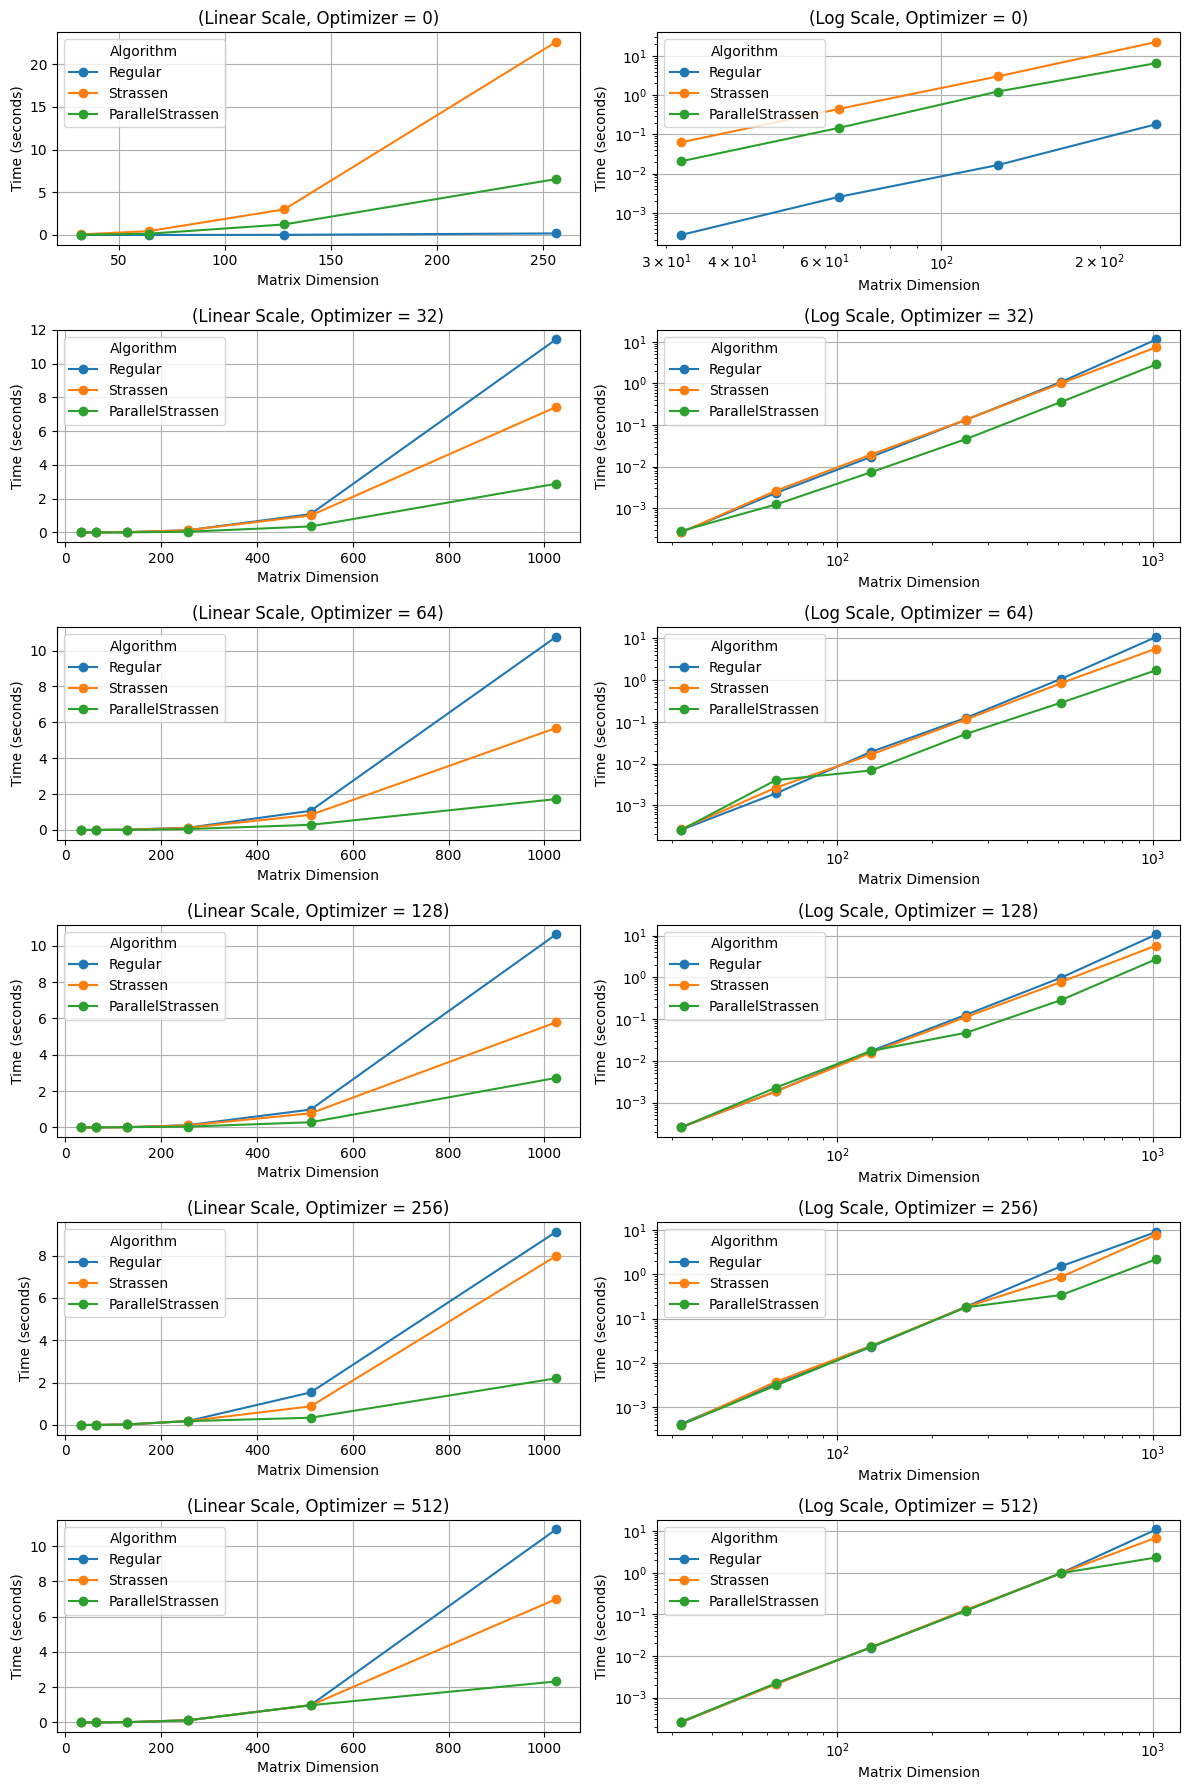

### O3 Optimization

#### Matrix Multiplication Benchmark (Optimizer = 0)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |           0 | 4.2715e-05  |   0.0113285 |         0.00481548 |
|          64 |           0 | 0.000203242 |   0.100238  |         0.0314532  |
|         128 |           0 | 0.00210966  |   0.752165  |         0.289651   |
|         256 |           0 | 0.0207203   |   4.97625   |         1.34559    |
|         512 |           0 | 0.0791174   |  34.4782    |        10.2042     |
|        1024 |           0 | 0.964004    | 244.097     |        74.6386     |

#### Matrix Multiplication Benchmark (Optimizer = 32)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |          32 | 2.877e-05   | 3.2043e-05  |        3.1491e-05  |
|          64 |          32 | 0.000163438 | 0.000351047 |        0.000313612 |
|         128 |          32 | 0.00115281  | 0.00267585  |        0.00123156  |
|         256 |          32 | 0.0101265   | 0.0208587   |        0.00660033  |
|         512 |          32 | 0.0891612   | 0.15331     |        0.0440255   |
|        1024 |          32 | 0.901791    | 1.08151     |        0.29763     |

#### Matrix Multiplication Benchmark (Optimizer = 64)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |   Strassen |   ParallelStrassen |
|------------:|------------:|------------:|-----------:|-------------------:|
|          32 |          64 | 5.6314e-05  | 3.2985e-05 |        3.1915e-05  |
|          64 |          64 | 0.000186306 | 0.00020533 |        0.000205863 |
|         128 |          64 | 0.00120069  | 0.00164378 |        0.00119545  |
|         256 |          64 | 0.0109782   | 0.0161768  |        0.00748969  |
|         512 |          64 | 0.0840456   | 0.0927095  |        0.0288906   |
|        1024 |          64 | 0.999276    | 0.664771   |        0.2021      |

#### Matrix Multiplication Benchmark (Optimizer = 128)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |   Strassen |   ParallelStrassen |
|------------:|------------:|------------:|-----------:|-------------------:|
|          32 |         128 | 3.0735e-05  | 3.3819e-05 |        3.3257e-05  |
|          64 |         128 | 0.000183144 | 0.00018787 |        0.000186641 |
|         128 |         128 | 0.00125631  | 0.00128477 |        0.0015131   |
|         256 |         128 | 0.00969506  | 0.0113963  |        0.00436115  |
|         512 |         128 | 0.0967772   | 0.0821171  |        0.0287599   |
|        1024 |         128 | 1.02038     | 0.541856   |        0.177804    |

#### Matrix Multiplication Benchmark (Optimizer = 256)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |         256 | 3.2406e-05  | 3.7455e-05  |        3.4672e-05  |
|          64 |         256 | 0.000187878 | 0.000206213 |        0.000197715 |
|         128 |         256 | 0.00138932  | 0.00175572  |        0.00142041  |
|         256 |         256 | 0.0115735   | 0.0122336   |        0.0118989   |
|         512 |         256 | 0.0845883   | 0.0884953   |        0.0298009   |
|        1024 |         256 | 0.898509    | 0.643382    |        0.206148    |

#### Matrix Multiplication Benchmark (Optimizer = 512)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |    Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|-----------:|------------:|-------------------:|
|          32 |         512 | 3.9745e-05 | 4.3001e-05  |        4.1358e-05  |
|          64 |         512 | 0.00018654 | 0.000212359 |        0.000199305 |
|         128 |         512 | 0.00143223 | 0.00131831  |        0.00138166  |
|         256 |         512 | 0.0092     | 0.0127708   |        0.0114197   |
|         512 |         512 | 0.0841725  | 0.120792    |        0.11574     |
|        1024 |         512 | 0.97125    | 0.790539    |        0.29865     |

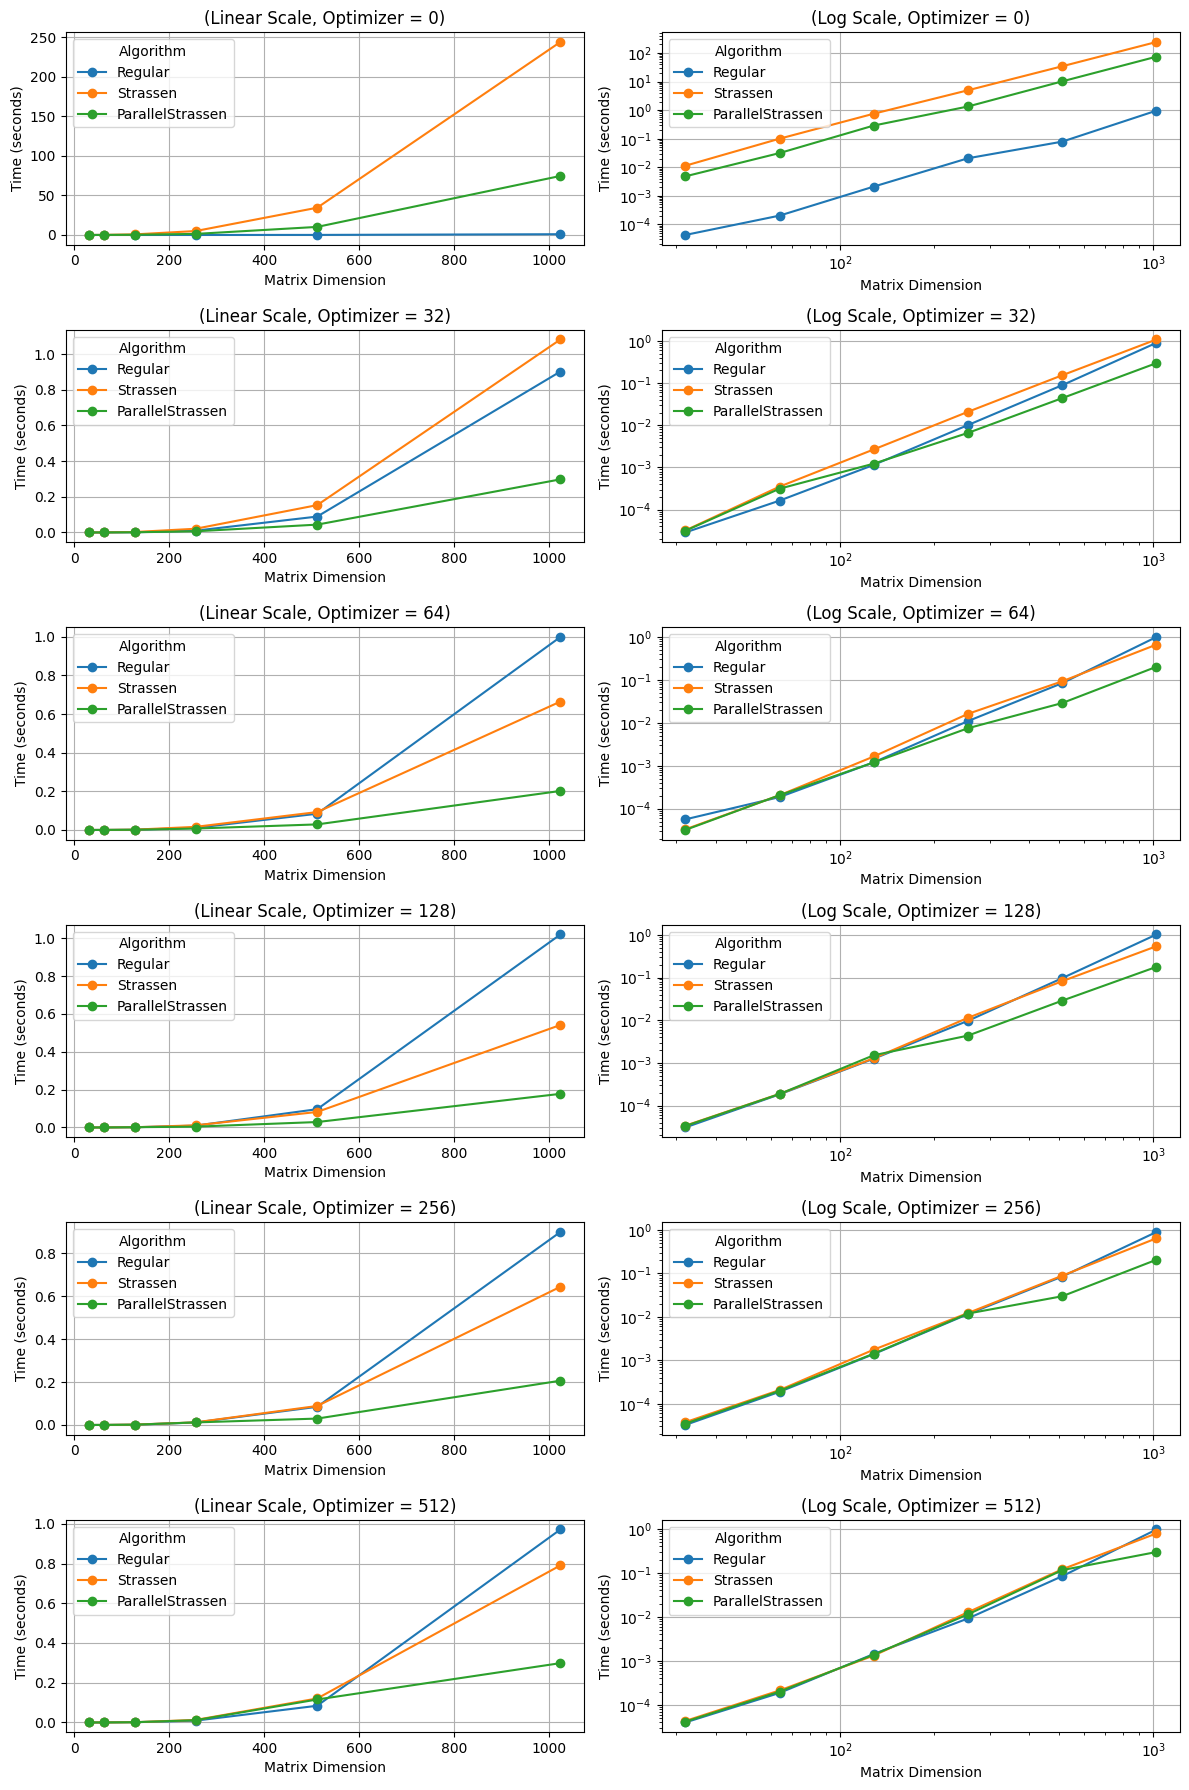

### Fast Optimization

#### Matrix Multiplication Benchmark (Optimizer = 0)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |           0 | 4.1744e-05  |   0.0118747 |         0.00577445 |
|          64 |           0 | 0.000214966 |   0.133811  |         0.0389366  |
|         128 |           0 | 0.00185922  |   0.940815  |         0.248845   |
|         256 |           0 | 0.0124684   |   6.08681   |         1.51739    |
|         512 |           0 | 0.101398    |  41.2498    |        10.1564     |
|        1024 |           0 | 0.94343     | 264.168     |        72.5697     |

#### Matrix Multiplication Benchmark (Optimizer = 32)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |          32 | 2.7303e-05  | 3.1685e-05  |        3.1723e-05  |
|          64 |          32 | 0.000163149 | 0.000346405 |        0.000411502 |
|         128 |          32 | 0.00116534  | 0.00265723  |        0.00128914  |
|         256 |          32 | 0.00994013  | 0.0216284   |        0.00661519  |
|         512 |          32 | 0.090669    | 0.159143    |        0.0408796   |
|        1024 |          32 | 1.04937     | 1.1628      |        0.302465    |

#### Matrix Multiplication Benchmark (Optimizer = 64)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |          64 | 2.679e-05   | 3.4587e-05  |        3.119e-05   |
|          64 |          64 | 0.000163366 | 0.000183962 |        0.000188339 |
|         128 |          64 | 0.00116714  | 0.00158092  |        0.000885069 |
|         256 |          64 | 0.0104871   | 0.0129336   |        0.00418671  |
|         512 |          64 | 0.087013    | 0.0879332   |        0.0315433   |
|        1024 |          64 | 0.892417    | 0.655465    |        0.20092     |

#### Matrix Multiplication Benchmark (Optimizer = 128)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |         128 | 2.6788e-05  | 3.1932e-05  |         3.1158e-05 |
|          64 |         128 | 0.000163026 | 0.000179391 |         0.00018225 |
|         128 |         128 | 0.00109485  | 0.0011884   |         0.00133997 |
|         256 |         128 | 0.00924835  | 0.0104527   |         0.00480108 |
|         512 |         128 | 0.0871703   | 0.0803391   |         0.0261026  |
|        1024 |         128 | 0.991273    | 0.549684    |         0.175889   |

#### Matrix Multiplication Benchmark (Optimizer = 256)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |    Strassen |   ParallelStrassen |
|------------:|------------:|------------:|------------:|-------------------:|
|          32 |         256 | 3.8783e-05  | 3.5974e-05  |         3.6759e-05 |
|          64 |         256 | 0.000171883 | 0.000186006 |         0.00018569 |
|         128 |         256 | 0.00163827  | 0.00170844  |         0.00139796 |
|         256 |         256 | 0.0219017   | 0.0227579   |         0.022861   |
|         512 |         256 | 0.103949    | 0.0868712   |         0.0301867  |
|        1024 |         256 | 0.956912    | 0.616742    |         0.206073   |

#### Matrix Multiplication Benchmark (Optimizer = 512)

> Time is in seconds, lower is better

|   Dimension |   Optimizer |     Regular |   Strassen |   ParallelStrassen |
|------------:|------------:|------------:|-----------:|-------------------:|
|          32 |         512 | 2.7424e-05  | 3.3581e-05 |        3.2745e-05  |
|          64 |         512 | 0.000179022 | 0.00019793 |        0.000190848 |
|         128 |         512 | 0.00117385  | 0.00126587 |        0.00132701  |
|         256 |         512 | 0.0105865   | 0.0121425  |        0.0120262   |
|         512 |         512 | 0.0994969   | 0.116651   |        0.119715    |
|        1024 |         512 | 0.990697    | 0.833752   |        0.292339    |

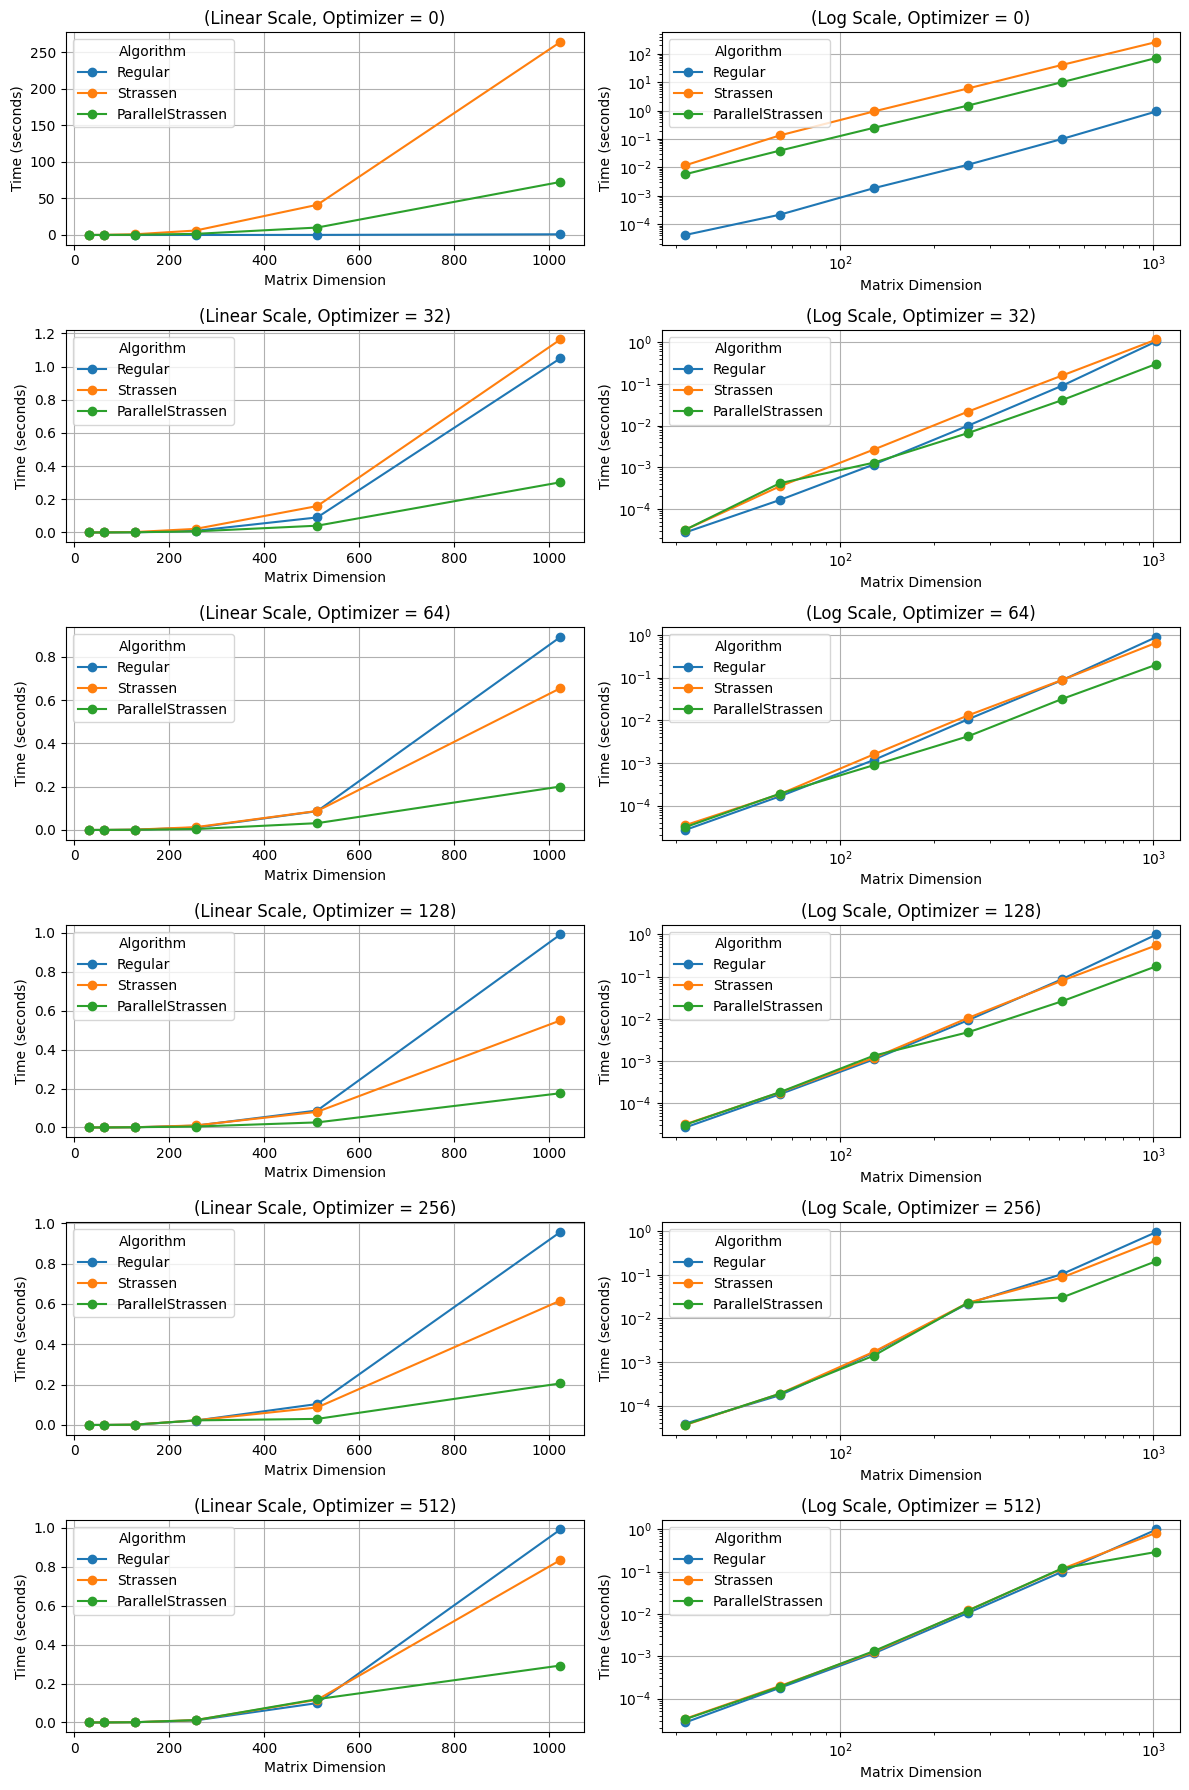

In [6]:
display(Markdown('### Zero Optimization'))
plot_matrix_benchmark('./O0/matrix_benchmark.csv')
display(Markdown('### O3 Optimization'))
plot_matrix_benchmark('./O3/matrix_benchmark.csv')
display(Markdown('### Fast Optimization'))
plot_matrix_benchmark('./fast/matrix_benchmark.csv')

#### Regarding weird performance of Strassen multiplication.
Regular multiplication is faster than Strassen multiplication for smaller matrices. This is not only due to the overhead of the Strassen algorithm but also because complier optimizations are effective for smaller matrices due to cache and hardware support.
The dim=1024 , regular one satifies this claim as without hardware support within 1s multiplication is not possible.
### Parallel Strassen multiplication - Performance Degradation
This boost is achieved when we use thresholds. However the greater the better is not the case. After optimization=128 the performance starts to degrade. For the parallel algorithm, performance is better for lower optimization values. The best perfomance is observed for optimization=0. This maybe due to memory model limitations - The processor tries to use SIMD instructions for the regular multiplication, which limits parallel instruction due to memory port bottleneck.

### Strassen multiplication - Performance improvement over dimension increase
Strassen multiplication outperforms regular multiplication for larger matrices. As the matrix grow larger the cache misses becomes higher. The regular algorithm looses its advantage over the Strassen algorithm. 

# Insights from the benchmarking
* Parallelization can be a double-edged sword. With proper calibration, it can provide a significant performance boost. However, if not properly optimized, it can lead to performance degradation.
* The Strassen algorithm is more efficient than the naive approach for large matrices, but it may not be the best choice for smaller matrices due to overhead. The threshold for switching between the two methods should be carefully chosen.
* Divide and conquer algorithms can provide significat performace boosts.
* Memory model limitations can affect the performance of parallel algorithms. The processor tries to use SIMD instructions for the regular multiplication, which limits parallel instruction due to memory port bottleneck.

In [4]:
import pandas as pd
from IPython.display import Markdown
import matplotlib.pyplot as plt
def plot_closest_pair_benchmark(file_path):
    df = pd.read_csv(file_path)
    df_md = df.to_markdown(index=False)
    display(Markdown('#### Closest Pair Benchmark'))
    display(Markdown('> Time is in seconds, lower is better'))
    display(Markdown(df_md))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    df.plot(x='NumPoints', y=['DC', 'DCYPreSorted', 'DCParallelized', 'DCAllThreaded', 'NSquare'], kind='line', marker='o', ax=ax1)
    ax1.set_xlabel('Number of Points')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Performance of Closest Pair Algorithms (Linear Scale)')
    ax1.legend(title='Algorithm')
    ax1.grid(True)

    df.plot(x='NumPoints', y=['DC', 'DCYPreSorted', 'DCParallelized', 'DCAllThreaded', 'NSquare'], kind='line', marker='o', logx=True, logy=True, ax=ax2)
    ax2.set_xlabel('Number of Points')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Performance of Closest Pair Algorithms (Log Scale)')
    ax2.legend(title='Algorithm')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
def plot_matrix_benchmark(file_path):
    matrix_df = pd.read_csv(file_path)
    optimizers = matrix_df['Optimizer'].unique()
    fig, axes = plt.subplots(len(optimizers), 2, figsize=(12, 18))
    for i, optimizer in enumerate(optimizers):
        subset_df = matrix_df[matrix_df['Optimizer'] == optimizer]
        subset_df_md = subset_df.to_markdown(index=False)
        display(Markdown(f'#### Matrix Multiplication Benchmark (Optimizer = {optimizer})'))
        display(Markdown('> Time is in seconds, lower is better'))
        display(Markdown(subset_df_md))

        # Linear scale plot
        subset_df.plot(x='Dimension', y=['Regular', 'Strassen', 'ParallelStrassen'], kind='line', marker='o', ax=axes[i, 0])
        axes[i, 0].set_xlabel('Matrix Dimension')
        axes[i, 0].set_ylabel('Time (seconds)')
        axes[i, 0].set_title(f'(Linear Scale, Optimizer = {optimizer})')
        axes[i, 0].legend(title='Algorithm')
        axes[i, 0].grid(True)

        # Logarithmic scale plot
        subset_df.plot(x='Dimension', y=['Regular', 'Strassen', 'ParallelStrassen'], kind='line', marker='o', logx=True, logy=True, ax=axes[i, 1])
        axes[i, 1].set_xlabel('Matrix Dimension')
        axes[i, 1].set_ylabel('Time (seconds)')
        axes[i, 1].set_title(f'(Log Scale, Optimizer = {optimizer})')
        axes[i, 1].legend(title='Algorithm')
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()